In [31]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.fftpack import fft
import math

import cv2

In [32]:
filename = "dolphinsound.wav"
data, fs = sf.read(filename)
ch1 = data[:,0]

In [33]:
start_time = (27)
end_time = (29)

fs = 96000

## stft parameters
fft_number = 1024
overlab = 0.5
window_type = 'hann'

# hydrophone spec, transfer the voltage data to pressure level
sensitivity = 211

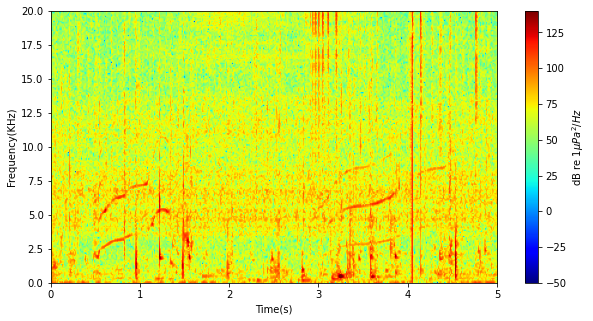

In [34]:
sample_time_series = ch1[fs*start_time:fs*end_time]
PSD = []

hop_size = math.ceil(fft_number*(1-overlab))

window = scipy.signal.get_window(window_type, fft_number, fftbins=True)

end_index = fft_number
half_size = math.ceil((fft_number+1)/2)
while(end_index<len(sample_time_series)):
    windowed_data = window*sample_time_series[end_index-fft_number:end_index]
    z = fft(windowed_data)[:half_size]/fft_number*2
    psd = 20*np.log10(abs(z)**2) + sensitivity
    PSD.append(psd)
    end_index += hop_size
PSD = np.array(PSD)

fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(PSD.T, cmap='jet',  vmin=-50, vmax=140, origin='lower', aspect='auto', 
               interpolation='hanning', extent=(0, 5, 0, fs//2/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

In [35]:
#################################################
# first step, click removal through time series #
#################################################

# parameters:
# 1. threshold
# 2. power

def removeClick(x):
    thresh = 5
    power = 6
    x = np.array(x*100)
    m = np.mean(x)
    SD = np.std(x)
    w = 1.0/(1+((x-m)/thresh*SD)**power)
    return w*x/100

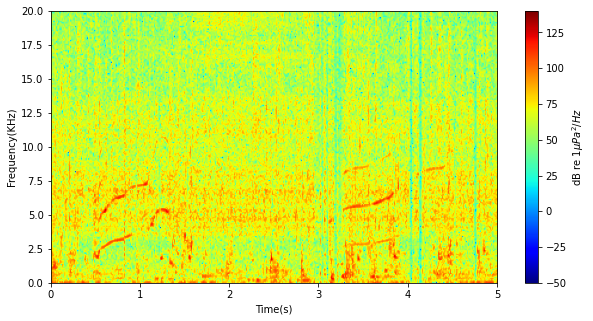

In [36]:
#############################
# Second step, STFT process #
#############################

# parameters:
# 1. fft_number
# 2. window_type
# 3. overlap ratio

sample_time_series = ch1[fs*start_time:fs*end_time]
PSD_clickRemoval = []

hop_size = math.ceil(fft_number*(1-overlab))

window = scipy.signal.get_window(window_type, fft_number, fftbins=True)

end_index = fft_number
half_size = math.ceil((fft_number+1)/2)
while(end_index<=len(sample_time_series)):
    weighted_data = removeClick(sample_time_series[end_index-fft_number:end_index])
    windowed_data = window*weighted_data
    z = fft(windowed_data)[:half_size]/fft_number*2
    psd = 20*np.log10(abs(z)**2) + sensitivity
    PSD_clickRemoval.append(psd)
    end_index += hop_size
PSD_clickRemoval = np.array(PSD_clickRemoval)

fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(PSD_clickRemoval.T, cmap='jet',  vmin=-50, vmax=140, origin='lower', aspect='auto', 
               interpolation='hanning', extent=(0, 5, 0, fs//2/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

In [38]:
#############################
# Third step, image bluring #
#############################

# applying median bluring



median_blur = cv2.medianBlur(PSD_clickRemoval.astype(np.float32),3)

In [67]:
##################################################
# fourth step, band passing & narrow band filter #
##################################################

# 1. 
# 2. take advantage of whistle features, narrow band width

# parameters:
# 1. start freq
# 2. end freq
# 3. threshold
# 4. width

start_fre = 2500
end_fre = 10000

threshold = 2
frequency_width = 300

f = np.arange(half_size)*fs/fft_number
df = fs/fft_number


f = np.arange(half_size)*fs/fft_number
df = fs/fft_number
start_index = math.floor((start_fre)/df)
end_index = math.ceil((end_fre)/df)
width_size = math.ceil(frequency_width/2/df)

narrow_band = []

f_select_s = 2500
f_select_e = 10000
s_index = math.floor((f_select_s)/df)
e_index = math.ceil((f_select_e)/df)

median_f = np.median(median_blur[:,s_index:e_index],axis=1)
median_f = median_f.reshape(len(median_f),1)
SNR = 10*np.log10(median_blur[:,start_index:end_index]/median_f)
narrow_band = SNR>1.5
# narrow_band = cv2.medianBlur(narrow_band.astype(np.float32),3)

In [71]:
SNR.std()*3+SNR.mean()

1.429224606603384

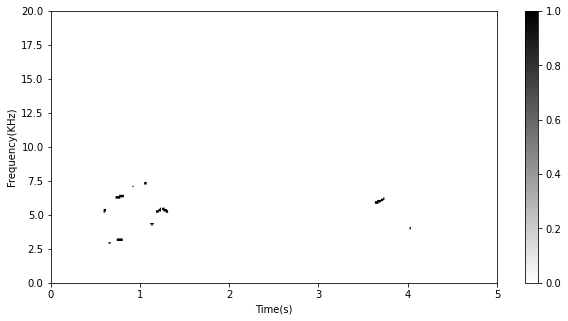

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(narrow_band.T.astype(np.int8), cmap="binary", origin='lower', aspect='auto',
               interpolation=None, extent=(0, 5, f[start_index]/1000, f[end_index]/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.show()

In [46]:
frequency_width = 50
time_duration = 0.02

dt = hop_size/96000
df = fs/fft_number

col_size = math.ceil(time_duration/dt)
row_size = math.ceil(frequency_width/df)

image_row = narrow_band.T.shape[0]
image_col = narrow_band.T.shape[1]

padding = np.zeros((image_row+row_size-1, image_col+col_size-1))
padding[row_size//2:row_size//2+image_row,col_size//2:col_size//2+image_col] = narrow_band.T

print("col size: {}".format(col_size))
print("row size: {}".format(row_size))
print("image row size: {}".format(image_row))
print("image col size: {}".format(image_col))
detection = np.zeros((image_row, image_col))
for i in range(image_row):
    for j in range(image_col):
        segment = padding[i:i+row_size,j:j+col_size]
        detection[i,j] = np.sum(np.sum(segment, axis=0)>0)

col size: 4
row size: 1
image row size: 81
image col size: 374


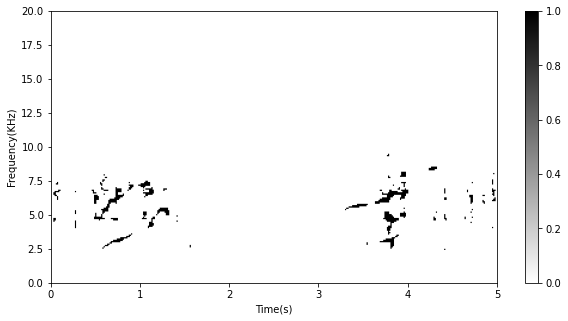

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow((detection==4).astype(np.int8), cmap='binary',  origin='lower', aspect='auto',
               interpolation='hanning', extent=(0, 5, f[start_index]/1000, f[end_index]/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.show()

In [48]:
from sklearn.cluster import DBSCAN

In [49]:
(x,y) = np.nonzero((detection==4).T)
c = np.array([x,y]).T

In [50]:
clustering=DBSCAN(eps=20,min_samples=10).fit(c)

In [51]:
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [28]:
point = c[clustering.labels_!=-1]
new_label = clustering.labels_[clustering.labels_!=-1]

In [29]:
point_x = point.T[0]*dt
point_y = point.T[1]*df/1000+3

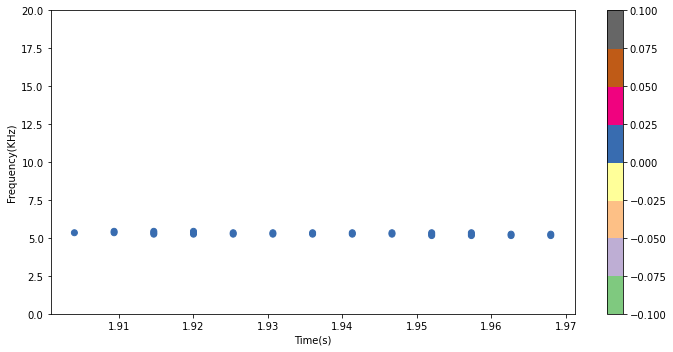

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
im = ax.scatter(point_x,point_y, c=new_label, cmap="Accent")

ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.tight_layout()